In [1]:
import pickle
import json, os
import numpy as np  
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
def load_split(data_path):
    """
    Load sentiment data from a JSON file and preprocess it into a DataFrame.

    Args:
    - data_path (str): Path to the JSON file containing sentiment data.

    Returns:
    - pandas.DataFrame: Preprocessed DataFrame containing text and sentiment labels.
    """
    # Load data from JSON file
    with open(data_path, 'r') as f:
        data = json.load(f)
    
    # Prepare a dictionary to store the preprocessed data
    data_updated = {"Text": [], "Sentiment": []}

    # Extract text and sentiment labels from the loaded data and store in the dictionary
    for d in data:
        data_updated["Text"].append(d["text"])
        data_updated["Sentiment"].append(d["opinions"][0]['sentiment'])

    # Convert the dictionary to a DataFrame and return
    return pd.DataFrame(data_updated)


def load_sa_data(n_products=100):
    """
    Load sentiment analysis data either from a CSV file or from JSON files,
    preprocess it, and save as a CSV file if not already available.

    Args:
    - n_products (int): Number of unique product IDs to generate.

    Returns:
    - pandas.DataFrame: DataFrame containing preprocessed sentiment analysis data.
    """
    # Check if the CSV file already exists
    if not os.path.exists('data/sentiment/sentiment_analysis.csv'):
        # Load sentiment data from JSON files
        data_dev = load_split('data/sentiment/sentitel_dev.json')
        data_train = load_split('data/sentiment/sentitel_train.json')
        data_test = load_split('data/sentiment/sentitel_test.json')

        # Concatenate the data and shuffle rows
        data = pd.concat([data_dev, data_train, data_test], ignore_index=True)
        data = data.sample(frac=1).reset_index(drop=True)

        # Generate random product IDs and add them as a new column
        product_ids = np.arange(1, n_products+1)
        product_id_array = np.random.choice(product_ids, data.shape[0], replace=True)
        data["ProdID"] = product_id_array

        # Save the preprocessed data as a CSV file
        data.to_csv('data/sentiment/sentiment_analysis.csv', index=False)
    
    # If the CSV file exists, load and return it
    return pd.read_csv('data/sentiment/sentiment_analysis.csv')


In [3]:
# Load sentiment analysis data using the load_sa_data function
data = load_sa_data()

# Display the first few rows of the loaded data to verify its structure
data.head()

,Text,Sentiment,ProdID
0,AirtelUg am still having trouble using Cloudfl...,Negative,41
1,africellUG Thanks so much,Positive,71
2,AirtelUg Ure slowly becoming my favourite keep...,Positive,87
3,digitaldidan Oke lets not discredit AirtelUg ...,Positive,78
4,mtnug I cant buy data via mobile money Wsup,Negative,83


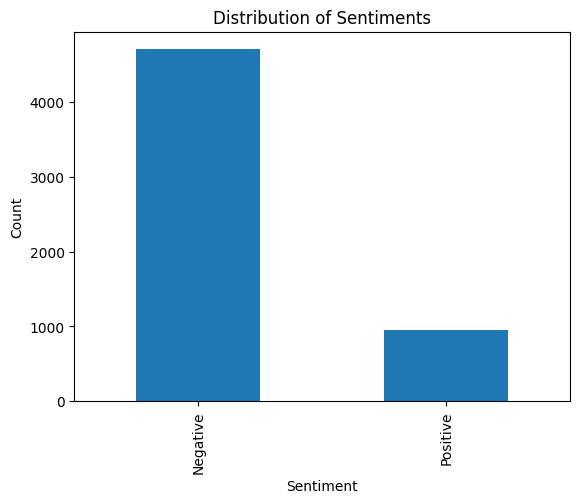

In [4]:
# Count the occurrences of each sentiment category
sentiment_counts = data["Sentiment"].value_counts()

# Plot the distribution of sentiments using a bar plot
sentiment_counts.plot(kind='bar')

# Add labels and title
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()

In [5]:
# Map sentiment labels to numerical values
data["Sentiment"] = data["Sentiment"].map({
    'Negative': 0,
    'Positive': 1
})

# Extract text and sentiment values from the DataFrame
texts = data["Text"].values
sentiments = data["Sentiment"].values

In [6]:
# Calculate class weights for imbalance handling
class_weights = {}

# Iterate over the two classes
for i in range(2):
    # Calculate class weight for each class
    class_weights[i] = len(sentiments) / (2 * np.sum(sentiments == i))

# Print the calculated class weights
print(class_weights)

{0: 0.6017435679353604, 1: 2.9571577847439916}


In [7]:
# Check if the tokenizer pickle file exists, if not, create and save a new tokenizer
if not os.path.exists('weights/sentiment/sentiment_analysis.pickle'):
    # Initialize a new Tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    
    # Fit the Tokenizer on the text data
    tokenizer.fit_on_texts(texts)

    # Save the tokenizer to a pickle file
    with open('weights/sentiment/sentiment_analysis.pickle', 'wb') as f:
        pickle.dump(tokenizer, f)

# If the tokenizer pickle file exists, load the tokenizer from the file
else:
    # Load the tokenizer from the pickle file
    with open('weights/sentiment/sentiment_analysis.pickle', 'rb') as f:
        tokenizer = pickle.load(f)

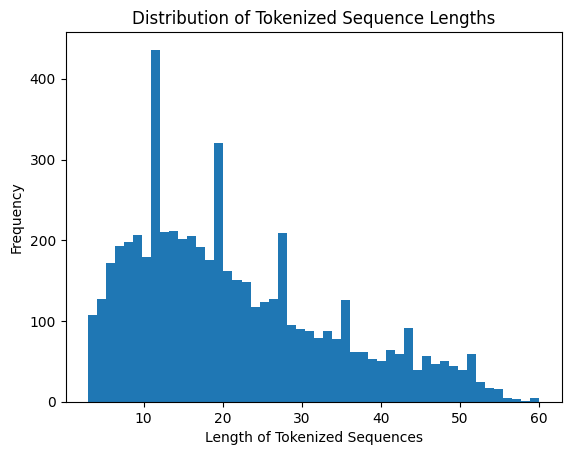

In [8]:
# Convert the texts to sequences using the tokenizer
X_tokenized = tokenizer.texts_to_sequences(texts)

# Plot a histogram of the lengths of the tokenized sequences
plt.hist([len(x) for x in X_tokenized], bins=50)
plt.xlabel('Length of Tokenized Sequences')
plt.ylabel('Frequency')
plt.title('Distribution of Tokenized Sequence Lengths')
plt.show()

In [9]:
# Pad the tokenized sequences to ensure uniform length
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_tokenized, padding='post')

In [10]:
def build_sa_model(vocab_size, embedding_dim, max_length):
    # Define the input layer
    input_layer = tf.keras.layers.Input(shape=(max_length,))
    
    # Embedding layer
    embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)(input_layer)
    
    # LSTM layers
    lstm_layer = tf.keras.layers.LSTM(128, return_sequences=True)(embedding_layer)
    lstm_layer = tf.keras.layers.LSTM(128)(lstm_layer)
    
    # Dense layers
    dense_layer = tf.keras.layers.Dense(128, activation='relu')(lstm_layer)
    dense_layer = tf.keras.layers.Dense(32, activation='relu')(dense_layer)
    
    # Output layer
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)

    # Build the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    # Print model summary
    model.summary() 
    
    return model

# This function defines a sentiment analysis model using Keras Functional API.
# It consists of an input layer, an embedding layer, two LSTM layers, and two dense layers, followed by a sigmoid output layer.

In [11]:
model = build_sa_model(
                    len(tokenizer.word_index) + 1, 
                    256, 
                    X_padded.shape[1]
                    )

# Compile the model
model.compile(
            optimizer='adam', 
            loss='binary_crossentropy', 
            metrics=[
                    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                    tf.keras.metrics.Precision(name='precision')
                    ]
            )

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='accuracy', 
                                                patience=5
                                                )

# Train the model
model.fit(
        X_padded, 
        sentiments, 
        epochs=100, 
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stopping]
        )



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding (Embedding)       (None, 60, 256)           2205696   
                                                                 
 lstm (LSTM)                 (None, 60, 128)           197120    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33   

In [12]:
model.save('weights/sentiment/sentiment_analysis.h5')

c:\Users\namma\anaconda3\envs\SentiChurn\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


177/177 [==============================] - 3s 16ms/step


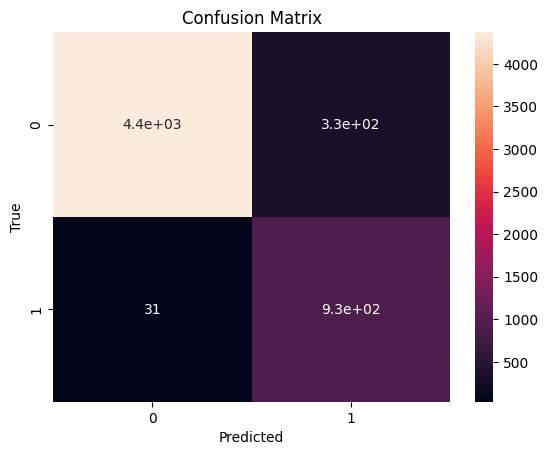

In [13]:
# Compute the confusion matrix
cm = confusion_matrix(sentiments, model.predict(X_padded) > 0.5)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()